## 1. Installation and Imports

In [50]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingWarmRestarts

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import open_clip

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: mps


## 2. Load BiomedCLIP Model

In [37]:
print("Loading BiomedCLIP model...")

model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
biomedclip_model, _, biomedclip_preprocess = open_clip.create_model_and_transforms(model_name)
biomedclip_tokenizer = open_clip.get_tokenizer(model_name)

# Move to device and set to eval mode
biomedclip_model = biomedclip_model.to(device)
biomedclip_model.eval()

# Freeze BiomedCLIP parameters
for param in biomedclip_model.parameters():
    param.requires_grad = False

print("BiomedCLIP model loaded successfully!")

# Get embedding dimensions
with torch.no_grad():
    dummy_image = torch.randn(1, 3, 224, 224).to(device)
    dummy_text = biomedclip_tokenizer(["test"]).to(device)
    
    image_features = biomedclip_model.encode_image(dummy_image)
    text_features = biomedclip_model.encode_text(dummy_text)
    
    vision_dim = image_features.shape[-1]
    text_dim = text_features.shape[-1]

print(f"Vision embedding dim: {vision_dim}")
print(f"Text embedding dim: {text_dim}")

Loading BiomedCLIP model...
BiomedCLIP model loaded successfully!
Vision embedding dim: 512
Text embedding dim: 512


## 3. Data Loading and Preprocessing

In [38]:
# Configuration
DATA_DIR = "./SLAKE1.0"  
IMG_DIR = os.path.join(DATA_DIR, "imgs")
ANNOTATION_FILE = os.path.join(DATA_DIR, "train.json") 

if os.path.exists(DATA_DIR):
    print(f"✓ Data directory found")
else:
    print(f"Data directory NOT FOUND")

✓ Data directory found


In [39]:
def load_slake_data(annotation_file, language='en'):
    """
    Load SLAKE dataset with proper question type tracking.
    """
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    
    samples = []
    skipped = 0
    
    # Track question type distribution
    closed_count = 0
    open_count = 0
    unknown_count = 0
    
    for item in data:
        q_lang = item.get('q_lang', item.get('qlang', 'en'))
        
        if language is not None and q_lang != language:
            skipped += 1
            continue
        
        # Extract question type (CLOSED or OPEN)
        # SLAKE uses different field names in different versions
        answer_type = None
        
        # Try common field names
        for field in ['answer_type', 'qtype', 'q_type', 'question_type', 'type']:
            if field in item:
                answer_type = str(item[field]).upper()
                break
        
        # Normalize variations
        if answer_type:
            if 'CLOSE' in answer_type:
                answer_type = 'CLOSED'
                closed_count += 1
            elif 'OPEN' in answer_type:
                answer_type = 'OPEN'
                open_count += 1
            else:
                answer_type = 'UNKNOWN'
                unknown_count += 1
        else:
            answer_type = 'UNKNOWN'
            unknown_count += 1
        
        samples.append({
            'image_id': item.get('img_id', item.get('image_id')),
            'image_name': item.get('img_name', item.get('image_name')),
            'question': item.get('question', ''),
            'answer': item.get('answer', ''),
            'answer_type': answer_type,  # CLOSED or OPEN
            'question_type': item.get('q_lang', 'unknown'),
            'language': q_lang
        })
    
    print(f"Loaded {len(samples)} English samples (skipped {skipped} non-English)")
    return samples

In [41]:
if os.path.exists(ANNOTATION_FILE):
    all_samples = load_slake_data(ANNOTATION_FILE, language='en')  
    print(f"\n✓ Loaded {len(all_samples)} English samples")
else:
    print(f"⚠️  Annotation file not found: {ANNOTATION_FILE}")
    all_samples = []  

Loaded 4919 English samples (skipped 4916 non-English)

✓ Loaded 4919 English samples


In [42]:
# Build answer vocabulary
def build_answer_vocab(samples, min_freq=1):
    """
    Build vocabulary for answers.
    """
    answer_counter = Counter([s['answer'].lower() for s in samples])
    
    vocab = {ans: idx for idx, (ans, count) in enumerate(answer_counter.items()) 
             if count >= min_freq}
    
    if '<unk>' not in vocab:
        vocab['<unk>'] = len(vocab)
    
    return vocab, answer_counter

answer_vocab, answer_counter = build_answer_vocab(all_samples, min_freq=1)
idx_to_answer = {idx: ans for ans, idx in answer_vocab.items()}

print(f"\nAnswer vocabulary size: {len(answer_vocab)}")
print(f"\nTop 10 most common answers:")
for ans, count in answer_counter.most_common(10):
    print(f"  {ans}: {count}")


Answer vocabulary size: 222

Top 10 most common answers:
  yes: 864
  no: 817
  lung: 253
  chest: 220
  liver: 159
  head: 129
  ct: 126
  brain: 117
  2: 109
  abdomen: 103


In [ ]:
# Filter and split data
def filter_samples(samples, vocab):
    filtered = []
    for s in samples:
        ans = s['answer'].lower()
        if ans in vocab:
            filtered.append(s)
    return filtered

filtered_samples = filter_samples(all_samples, answer_vocab)
print(f"\nFiltered to {len(filtered_samples)} samples with known answers")


NUM_SAMPLES = 1000 

filtered_samples = np.random.RandomState(42).choice(filtered_samples, NUM_SAMPLES, replace=False).tolist()
print(f"Using subset of {NUM_SAMPLES} samples")

# Stratified split for balanced train/val
answer_labels = [s['answer'].lower() for s in filtered_samples]

try:
    train_samples, temp_samples = train_test_split(
        filtered_samples, 
        test_size=0.3, 
        random_state=42,
        stratify=answer_labels
    )
    # Split temp into val and test
    temp_labels = [s['answer'].lower() for s in temp_samples]
    val_samples, test_samples = train_test_split(
        temp_samples,
        test_size=0.5,
        random_state=42,
        stratify=temp_labels
    )
    print("✓Using stratified split (answers balanced)")
except ValueError:
    print("Cannot stratify (some classes have only 1 sample)")
    train_samples, temp_samples = train_test_split(filtered_samples, test_size=0.3, random_state=42)
    val_samples, test_samples = train_test_split(temp_samples, test_size=0.5, random_state=42)

print(f"\nData split:")
print(f"  Train: {len(train_samples)} samples")
print(f"  Val: {len(val_samples)} samples")
print(f"  Test: {len(test_samples)} samples")


Filtered to 4919 samples with known answers
Using subset of 1000 samples
Cannot stratify (some classes have only 1 sample)

Data split:
  Train: 700 samples
  Val: 150 samples
  Test: 150 samples


## 4. Dataset Class

In [45]:
class MedVQADataset(Dataset):
    def __init__(self, samples, img_dir, answer_vocab, transform):
        self.samples = samples
        self.img_dir = img_dir
        self.answer_vocab = answer_vocab
        self.transform = transform
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, sample['image_name'])
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Create dummy image if file not found
            image = Image.new('RGB', (224, 224), color='gray')
        
        # Apply transform
        if self.transform:
            image = self.transform(image)
        
        # Get question and answer
        question = sample['question']
        answer = sample['answer'].lower()
        answer_label = self.answer_vocab.get(answer, self.answer_vocab['<unk>'])
        
        return {
            'image': image,
            'question': question,
            'answer_label': torch.tensor(answer_label, dtype=torch.long),
            'answer_text': answer
        }

# Create datasets
train_dataset = MedVQADataset(train_samples, IMG_DIR, answer_vocab, biomedclip_preprocess)
val_dataset = MedVQADataset(val_samples, IMG_DIR, answer_vocab, biomedclip_preprocess)
test_dataset = MedVQADataset(test_samples, IMG_DIR, answer_vocab, biomedclip_preprocess)

print(f"Datasets created successfully!")
print(f"Train: {len(train_dataset)}")
print(f"Val: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

Datasets created successfully!
Train: 700
Val: 150
Test: 150


## 5. Model Architecture

In [47]:
class MedVQAModelShared(nn.Module):
    def __init__(self, biomedclip_model, tokenizer, num_classes, vision_dim=768, text_dim=512, 
                 joint_dim=1024, dropout=0.3):
        super(MedVQAModelShared, self).__init__()
        
        self.biomedclip = biomedclip_model
        self.tokenizer = tokenizer
        
        # 1. Feature Projectors
        # Maps raw CLIP features to a shared latent space
        self.vision_proj = nn.Sequential(
            nn.Linear(vision_dim, joint_dim),
            nn.BatchNorm1d(joint_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.text_proj = nn.Sequential(
            nn.Linear(text_dim, joint_dim),
            nn.BatchNorm1d(joint_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 2. Gated Multimodal Fusion
        # This allows the model to "decide" which features are important
        self.gate_layer = nn.Sequential(
            nn.Linear(joint_dim, joint_dim),
            nn.Sigmoid()
        )
        
        # 3. Classifier
        self.classifier = nn.Sequential(
            nn.Linear(joint_dim, joint_dim // 2),
            nn.BatchNorm1d(joint_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(joint_dim // 2, num_classes)
        )

    def forward(self, images, questions):
        # --- Feature Extraction ---
        # We unfreeze the backbone (remove no_grad) to allow fine-tuning
        
        visual_features = self.biomedclip.encode_image(images)
        
        #text_tokens = self.tokenizer(questions, padding=True, truncation=True, return_tensors="pt").to(images.device)
        # BioMedCLIP (OpenCLIP-based) expects a list of strings
        text_tokens = self.tokenizer(questions).to(images.device)
        text_features = self.biomedclip.encode_text(text_tokens)
        
        # Normalize CLIP outputs
        visual_features = visual_features / visual_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # --- Joint Embedding ---
        v_emb = self.vision_proj(visual_features)
        t_emb = self.text_proj(text_features)
        
        # --- Gated Fusion ---
        # Element-wise product weighted by a learned gate
        fused_features = v_emb * t_emb
        gate = self.gate_layer(fused_features)
        joint_representation = fused_features * gate
        
        # --- Classification ---
        logits = self.classifier(joint_representation)
        return logits

In [48]:
model = MedVQAModelShared(
    biomedclip_model=biomedclip_model,
    tokenizer=biomedclip_tokenizer,
    num_classes=len(answer_vocab),
    vision_dim=vision_dim,
    text_dim=text_dim
)
model = model.to(device)

print(model.classifier)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Frozen parameters (BiomedCLIP): {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}")
print("=" * 80)

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=222, bias=True)
)

Total parameters: 198,646,751
Trainable parameters: 2,744,030
Frozen parameters (BiomedCLIP): 195,902,721


In [49]:
# Custom Focal Loss function

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        Focal Loss for addressing class imbalance.
        :param alpha: Balancing factor (can be a tensor of weights per class).
        :param gamma: Focusing parameter. Higher = more focus on hard examples.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Calculate standard cross entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Get the probability of the correct class (pt)
        pt = torch.exp(-ce_loss) 
        
        # Calculate Focal Loss: (1-pt)^gamma * ce_loss
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

## 6. Training Configuration - Optimized for Maximum Performance

In [51]:
# ===== HYPERPARAMETERS =====
BATCH_SIZE = 16  
NUM_EPOCHS = 50  
LEARNING_RATE = 5e-5  
WEIGHT_DECAY = 1e-4  
WARMUP_EPOCHS = 3  
GRADIENT_CLIP = 1.0  
EARLY_STOPPING_PATIENCE = 10  

def collate_fn(batch):
    """Custom collate function."""
    images = torch.stack([item['image'] for item in batch])
    questions = [item['question'] for item in batch]
    answer_labels = torch.stack([item['answer_label'] for item in batch])
    
    return {
        'images': images,
        'questions': questions,
        'answer_labels': answer_labels
    }

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

# Loss function and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Learning rate schedulers

def warmup_lambda(epoch):
    """Warmup for first few epochs."""
    if epoch < WARMUP_EPOCHS:
        return (epoch + 1) / WARMUP_EPOCHS
    return 1.0

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
cosine_scheduler = CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

print(f"Batch size: {BATCH_SIZE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Warmup epochs: {WARMUP_EPOCHS}")
print(f"Gradient clipping: {GRADIENT_CLIP}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")



Batch size: 16
Number of epochs: 50
Learning rate: 5e-05
Weight decay: 0.0001
Warmup epochs: 3
Gradient clipping: 1.0
Early stopping patience: 10


## 7. Training Functions

In [33]:
def train_epoch(model, loader, criterion, optimizer, device, epoch):
    """
    Train for one epoch with gradient clipping.
    """
    model.train()
    model.biomedclip.eval()  # Keep BiomedCLIP frozen
    
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} - Training')
    
    for batch in pbar:
        images = batch['images'].to(device)
        questions = batch['questions']
        labels = batch['answer_labels'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(images, questions)
        loss = criterion(logits, labels)
        
        # Backward pass with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%',
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    """
    Evaluate the model.
    """
    model.eval()
    
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            images = batch['images'].to(device)
            questions = batch['questions']
            labels = batch['answer_labels'].to(device)
            
            # Forward pass
            logits = model(images, questions)
            loss = criterion(logits, labels)
            
            # Get predictions
            _, predicted = torch.max(logits, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_predictions) * 100
    
    return avg_loss, accuracy, all_predictions, all_labels

## 8. Main Training Loop

In [ ]:
# Training history
#train_losses = []
#train_accs = []
#val_losses = []
#val_accs = []
#learning_rates = []
#
#best_val_acc = 0
#best_epoch = 0
#best_model_path = 'best_medvqa_maxperf.pth'
#patience_counter = 0
#
#print("\n" + "=" * 80)
#print("STARTING TRAINING - MAXIMUM PERFORMANCE MODE")
#print("=" * 80 + "\n")
#
#for epoch in range(NUM_EPOCHS):
#    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
#    print("-" * 80)
#    
#    # Train
#    train_loss, train_acc = train_epoch(
#        model, train_loader, criterion, optimizer, device, epoch
#    )
#    train_losses.append(train_loss)
#    train_accs.append(train_acc)
#    
#    # Validate
#    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
#    val_losses.append(val_loss)
#    val_accs.append(val_acc)
#    
#    # Learning rate scheduling
#    current_lr = optimizer.param_groups[0]['lr']
#    learning_rates.append(current_lr)
#    
#    if epoch < WARMUP_EPOCHS:
#        warmup_scheduler.step()
#    else:
#        cosine_scheduler.step(epoch - WARMUP_EPOCHS)
#    
#    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
#    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
#    print(f"Learning Rate: {current_lr:.2e}")
#    
#    # Save best model
#    if val_acc > best_val_acc:
#        best_val_acc = val_acc
#        best_epoch = epoch
#        patience_counter = 0
#        
#        torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'val_acc': val_acc,
#            'val_loss': val_loss,
#            'train_acc': train_acc,
#            'train_loss': train_loss,
#            'answer_vocab': answer_vocab,
#            'idx_to_answer': idx_to_answer,
#            'config': {
#                'fusion_type': FUSION_TYPE,
#                'hidden_dims': HIDDEN_DIMS,
#                'dropout': DROPOUT,
#                'batch_size': BATCH_SIZE,
#                'learning_rate': LEARNING_RATE,
#                'vision_dim': vision_dim,
#                'text_dim': text_dim,
#            }
#        }, best_model_path)
#        print(f"✓ Saved best model with val acc: {val_acc:.2f}%")
#    else:
#        patience_counter += 1
#        print(f"No improvement. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
#    
#    # Early stopping
#    if patience_counter >= EARLY_STOPPING_PATIENCE:
#        print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
#        print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch+1}")
#        break
#
#print("\n" + "=" * 80)
#print("TRAINING COMPLETED!")
#print("=" * 80)
#print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch+1}")
#print(f"Model saved to: {best_model_path}")
#print("=" * 80)


STARTING TRAINING - MAXIMUM PERFORMANCE MODE


Epoch 1/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]



Train Loss: 5.1951 | Train Acc: 1.86%
Val Loss: 5.2867 | Val Acc: 0.00%
Learning Rate: 5.00e-05
No improvement. Patience: 1/10

Epoch 2/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]



Train Loss: 4.6113 | Train Acc: 16.86%
Val Loss: 4.7595 | Val Acc: 35.33%
Learning Rate: 3.33e-05
✓ Saved best model with val acc: 35.33%

Epoch 3/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]



Train Loss: 4.0762 | Train Acc: 29.57%
Val Loss: 4.0573 | Val Acc: 40.00%
Learning Rate: 5.00e-05
✓ Saved best model with val acc: 40.00%

Epoch 4/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]



Train Loss: 3.4505 | Train Acc: 40.71%
Val Loss: 3.5402 | Val Acc: 45.33%
Learning Rate: 5.00e-05
✓ Saved best model with val acc: 45.33%

Epoch 5/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]



Train Loss: 3.0063 | Train Acc: 44.57%
Val Loss: 3.1558 | Val Acc: 46.00%
Learning Rate: 5.00e-05
✓ Saved best model with val acc: 46.00%

Epoch 6/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]



Train Loss: 2.5788 | Train Acc: 51.29%
Val Loss: 2.9654 | Val Acc: 47.33%
Learning Rate: 4.88e-05
✓ Saved best model with val acc: 47.33%

Epoch 7/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]



Train Loss: 2.3130 | Train Acc: 50.57%
Val Loss: 2.7154 | Val Acc: 51.33%
Learning Rate: 4.53e-05
✓ Saved best model with val acc: 51.33%

Epoch 8/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]



Train Loss: 2.1056 | Train Acc: 56.00%
Val Loss: 2.6155 | Val Acc: 52.00%
Learning Rate: 3.99e-05
✓ Saved best model with val acc: 52.00%

Epoch 9/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]



Train Loss: 1.9715 | Train Acc: 57.71%
Val Loss: 2.4081 | Val Acc: 50.00%
Learning Rate: 3.31e-05
No improvement. Patience: 1/10

Epoch 10/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]



Train Loss: 1.8816 | Train Acc: 56.57%
Val Loss: 2.3190 | Val Acc: 52.67%
Learning Rate: 2.55e-05
✓ Saved best model with val acc: 52.67%

Epoch 11/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]



Train Loss: 1.8089 | Train Acc: 54.71%
Val Loss: 2.3124 | Val Acc: 53.33%
Learning Rate: 1.79e-05
✓ Saved best model with val acc: 53.33%

Epoch 12/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]



Train Loss: 1.7589 | Train Acc: 59.14%
Val Loss: 2.3129 | Val Acc: 54.67%
Learning Rate: 1.11e-05
✓ Saved best model with val acc: 54.67%

Epoch 13/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]



Train Loss: 1.7058 | Train Acc: 60.00%
Val Loss: 2.2667 | Val Acc: 54.00%
Learning Rate: 5.68e-06
No improvement. Patience: 1/10

Epoch 14/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]



Train Loss: 1.7084 | Train Acc: 60.86%
Val Loss: 2.2234 | Val Acc: 55.33%
Learning Rate: 2.20e-06
✓ Saved best model with val acc: 55.33%

Epoch 15/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it]



Train Loss: 1.6735 | Train Acc: 61.43%
Val Loss: 2.1131 | Val Acc: 55.33%
Learning Rate: 5.00e-05
No improvement. Patience: 1/10

Epoch 16/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]



Train Loss: 1.5275 | Train Acc: 61.14%
Val Loss: 2.0594 | Val Acc: 54.67%
Learning Rate: 4.97e-05
No improvement. Patience: 2/10

Epoch 17/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]



Train Loss: 1.4704 | Train Acc: 62.57%
Val Loss: 2.0164 | Val Acc: 54.00%
Learning Rate: 4.88e-05
No improvement. Patience: 3/10

Epoch 18/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]



Train Loss: 1.3542 | Train Acc: 67.29%
Val Loss: 1.9320 | Val Acc: 56.00%
Learning Rate: 4.73e-05
✓ Saved best model with val acc: 56.00%

Epoch 19/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]



Train Loss: 1.2848 | Train Acc: 67.43%
Val Loss: 1.8452 | Val Acc: 54.67%
Learning Rate: 4.53e-05
No improvement. Patience: 1/10

Epoch 20/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]



Train Loss: 1.2188 | Train Acc: 67.86%
Val Loss: 1.8225 | Val Acc: 55.33%
Learning Rate: 4.28e-05
No improvement. Patience: 2/10

Epoch 21/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]



Train Loss: 1.1790 | Train Acc: 71.57%
Val Loss: 1.7977 | Val Acc: 58.00%
Learning Rate: 3.99e-05
✓ Saved best model with val acc: 58.00%

Epoch 22/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]



Train Loss: 1.1067 | Train Acc: 72.71%
Val Loss: 1.7536 | Val Acc: 59.33%
Learning Rate: 3.66e-05
✓ Saved best model with val acc: 59.33%

Epoch 23/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]



Train Loss: 1.0677 | Train Acc: 72.43%
Val Loss: 1.7436 | Val Acc: 57.33%
Learning Rate: 3.31e-05
No improvement. Patience: 1/10

Epoch 24/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]



Train Loss: 1.0259 | Train Acc: 74.00%
Val Loss: 1.7021 | Val Acc: 60.00%
Learning Rate: 2.93e-05
✓ Saved best model with val acc: 60.00%

Epoch 25/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]



Train Loss: 0.9633 | Train Acc: 76.00%
Val Loss: 1.7268 | Val Acc: 61.33%
Learning Rate: 2.55e-05
✓ Saved best model with val acc: 61.33%

Epoch 26/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]



Train Loss: 0.9479 | Train Acc: 75.43%
Val Loss: 1.7158 | Val Acc: 60.67%
Learning Rate: 2.17e-05
No improvement. Patience: 1/10

Epoch 27/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train Loss: 0.9420 | Train Acc: 77.00%
Val Loss: 1.6580 | Val Acc: 60.00%
Learning Rate: 1.79e-05
No improvement. Patience: 2/10

Epoch 28/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]



Train Loss: 0.9439 | Train Acc: 75.29%
Val Loss: 1.6429 | Val Acc: 60.00%
Learning Rate: 1.44e-05
No improvement. Patience: 3/10

Epoch 29/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train Loss: 0.8833 | Train Acc: 77.57%
Val Loss: 1.6333 | Val Acc: 59.33%
Learning Rate: 1.11e-05
No improvement. Patience: 4/10

Epoch 30/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]



Train Loss: 0.8773 | Train Acc: 77.86%
Val Loss: 1.6592 | Val Acc: 59.33%
Learning Rate: 8.18e-06
No improvement. Patience: 5/10

Epoch 31/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]



Train Loss: 0.8697 | Train Acc: 77.14%
Val Loss: 1.6531 | Val Acc: 60.00%
Learning Rate: 5.68e-06
No improvement. Patience: 6/10

Epoch 32/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]



Train Loss: 0.8723 | Train Acc: 75.29%
Val Loss: 1.6684 | Val Acc: 59.33%
Learning Rate: 3.67e-06
No improvement. Patience: 7/10

Epoch 33/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]



Train Loss: 0.8594 | Train Acc: 76.71%
Val Loss: 1.6289 | Val Acc: 62.00%
Learning Rate: 2.20e-06
✓ Saved best model with val acc: 62.00%

Epoch 34/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]



Train Loss: 0.8542 | Train Acc: 76.71%
Val Loss: 1.6365 | Val Acc: 61.33%
Learning Rate: 1.30e-06
No improvement. Patience: 1/10

Epoch 35/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]



Train Loss: 0.8366 | Train Acc: 77.71%
Val Loss: 1.6446 | Val Acc: 61.33%
Learning Rate: 5.00e-05
No improvement. Patience: 2/10

Epoch 36/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]



Train Loss: 0.8224 | Train Acc: 78.43%
Val Loss: 1.5719 | Val Acc: 62.00%
Learning Rate: 4.99e-05
No improvement. Patience: 3/10

Epoch 37/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]



Train Loss: 0.7614 | Train Acc: 80.29%
Val Loss: 1.5754 | Val Acc: 63.33%
Learning Rate: 4.97e-05
✓ Saved best model with val acc: 63.33%

Epoch 38/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]



Train Loss: 0.7253 | Train Acc: 80.71%
Val Loss: 1.5516 | Val Acc: 62.67%
Learning Rate: 4.93e-05
No improvement. Patience: 1/10

Epoch 39/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]



Train Loss: 0.7056 | Train Acc: 82.43%
Val Loss: 1.5440 | Val Acc: 62.67%
Learning Rate: 4.88e-05
No improvement. Patience: 2/10

Epoch 40/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]



Train Loss: 0.6496 | Train Acc: 84.29%
Val Loss: 1.5102 | Val Acc: 63.33%
Learning Rate: 4.81e-05
No improvement. Patience: 3/10

Epoch 41/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]



Train Loss: 0.6002 | Train Acc: 84.86%
Val Loss: 1.4922 | Val Acc: 62.67%
Learning Rate: 4.73e-05
No improvement. Patience: 4/10

Epoch 42/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]



Train Loss: 0.5708 | Train Acc: 85.43%
Val Loss: 1.4639 | Val Acc: 64.67%
Learning Rate: 4.64e-05
✓ Saved best model with val acc: 64.67%

Epoch 43/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]



Train Loss: 0.5478 | Train Acc: 86.14%
Val Loss: 1.4741 | Val Acc: 64.00%
Learning Rate: 4.53e-05
No improvement. Patience: 1/10

Epoch 44/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]



Train Loss: 0.4867 | Train Acc: 87.86%
Val Loss: 1.4716 | Val Acc: 64.67%
Learning Rate: 4.41e-05
No improvement. Patience: 2/10

Epoch 45/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]



Train Loss: 0.4802 | Train Acc: 87.86%
Val Loss: 1.4551 | Val Acc: 66.00%
Learning Rate: 4.28e-05
✓ Saved best model with val acc: 66.00%

Epoch 46/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]



Train Loss: 0.4597 | Train Acc: 88.57%
Val Loss: 1.4567 | Val Acc: 65.33%
Learning Rate: 4.14e-05
No improvement. Patience: 1/10

Epoch 47/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]



Train Loss: 0.4737 | Train Acc: 87.57%
Val Loss: 1.4234 | Val Acc: 65.33%
Learning Rate: 3.99e-05
No improvement. Patience: 2/10

Epoch 48/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]



Train Loss: 0.3908 | Train Acc: 90.43%
Val Loss: 1.4131 | Val Acc: 66.67%
Learning Rate: 3.83e-05
✓ Saved best model with val acc: 66.67%

Epoch 49/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]



Train Loss: 0.3914 | Train Acc: 91.00%
Val Loss: 1.4040 | Val Acc: 64.67%
Learning Rate: 3.66e-05
No improvement. Patience: 1/10

Epoch 50/50
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Train Loss: 0.3545 | Train Acc: 92.00%
Val Loss: 1.4158 | Val Acc: 66.67%
Learning Rate: 3.49e-05
No improvement. Patience: 2/10

TRAINING COMPLETED!
Best validation accuracy: 66.67% at epoch 48
Model saved to: best_medvqa_maxperf.pth


## 9. Training Visualization

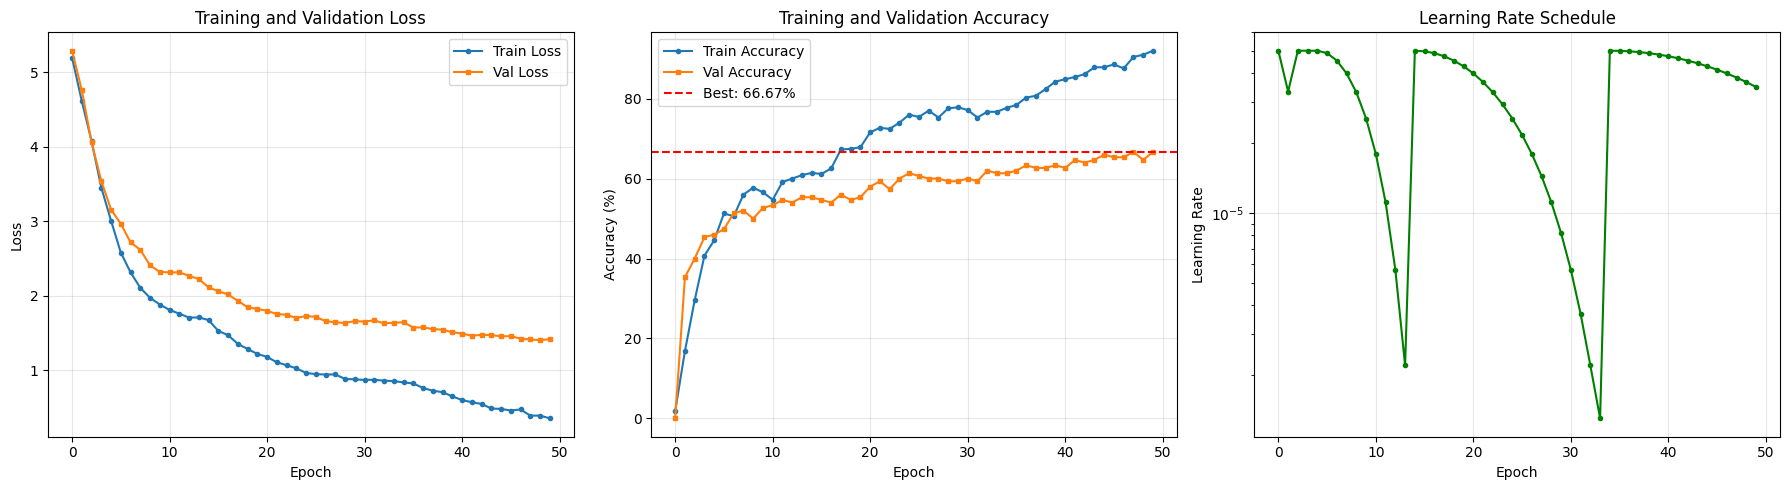


✓ Training curves saved to 'training_curves_maxperf.png'


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o', markersize=3)
axes[0].plot(val_losses, label='Val Loss', marker='s', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accs, label='Train Accuracy', marker='o', markersize=3)
axes[1].plot(val_accs, label='Val Accuracy', marker='s', markersize=3)
axes[1].axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best: {best_val_acc:.2f}%')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate plot
axes[2].plot(learning_rates, marker='o', markersize=3, color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_maxperf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Training curves saved to 'training_curves_maxperf.png'")

## 10. Test Evaluation

In [35]:
# Load best model
model = MedVQAModelShared(
    biomedclip_model=biomedclip_model,
    tokenizer=biomedclip_tokenizer,
    num_classes=len(answer_vocab),
    vision_dim=vision_dim,
    text_dim=text_dim
)
model = model.to(device)
best_model_path = 'best_medvqa_maxperf.pth'
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

print(f"\n{'='*80}")
print(f"FINAL TEST RESULTS")
print(f"{'='*80}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"{'='*80}")

✓ Loaded best model from epoch 48


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


FINAL TEST RESULTS
Test Loss: 1.5305
Test Accuracy: 64.00%


✓ Loaded best model from epoch 48

EVALUATING TEST SET BY QUESTION TYPE


Evaluating by Question Type: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


FINAL TEST RESULTS - BY QUESTION TYPE

                              OVERALL PERFORMANCE                               
--------------------------------------------------------------------------------
Total Samples: 150
Accuracy: 64.00%
Weighted F1 Score: 62.02%
Macro F1 Score: 31.37%
Loss: 1.7921

                                CLOSED QUESTIONS                                
--------------------------------------------------------------------------------
Samples: 63 (42.0%)
Accuracy: 65.08%
Weighted F1 Score: 65.18%
Macro F1 Score: 22.52%
Loss: 1.0672

                                 OPEN QUESTIONS                                 
--------------------------------------------------------------------------------
Samples: 87 (58.0%)
Accuracy: 63.22%
Weighted F1 Score: 59.78%
Macro F1 Score: 31.50%
Loss: 2.3170

                                   COMPARISON                                   
--------------------------------------------------------------------------------
Closed questi


/Users/haziqfaiz/Code/WOA7015-ADVANCED-MACHINE-LEARNING/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/haziqfaiz/Code/WOA7015-ADVANCED-MACHINE-LEARNING/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/haziqfaiz/Code/WOA7015-ADVANCED-MACHINE-LEARNING/venv/lib/python3.13/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_o

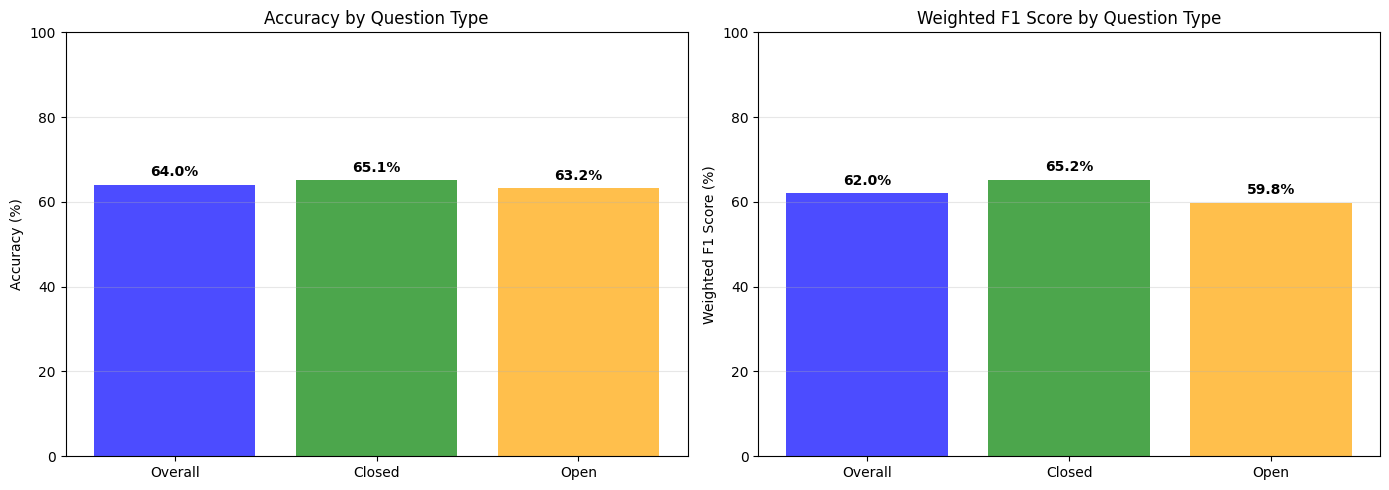

✓ Visualization saved to: test_results_by_question_type.png

QUESTION TYPE DISTRIBUTION IN PREDICTIONS

Answer Diversity:
  Closed: 6 unique answers out of 63 predictions
  Open: 40 unique answers out of 87 predictions
  Closed diversity: 9.5%
  Open diversity: 46.0%

Top 5 Predicted Answers (Closed):
  1. yes: 31 times (49.2%)
  2. no: 27 times (42.9%)
  3. lung: 2 times (3.2%)
  4. spleen: 1 times (1.6%)
  5. rectum: 1 times (1.6%)

Top 5 Predicted Answers (Open):
  1. chest: 10 times (11.5%)
  2. left lung, right: 5 times (5.7%)
  3. ct: 5 times (5.7%)
  4. head: 4 times (4.6%)
  5. x-ray: 4 times (4.6%)


In [ ]:
# Enhanced Test Evaluation - Separate Closed and Open Questions
# Add this cell to replace the original test evaluation

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")

# ==================================================================
# ENHANCED EVALUATION - SEPARATE CLOSED vs OPEN QUESTIONS
# ==================================================================

def evaluate_by_question_type(model, dataset, loader, criterion, device, idx_to_answer):
    """
    Evaluate model separately for closed and open questions.
    """
    model.eval()
    
    # Store results by question type
    closed_preds = []
    closed_labels = []
    closed_losses = []
    
    open_preds = []
    open_labels = []
    open_losses = []
    
    all_preds = []
    all_labels = []
    all_losses = []
    
    batch_idx = 0
    sample_idx = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating by Question Type'):
            images = batch['images'].to(device)
            questions = batch['questions']
            labels = batch['answer_labels'].to(device)
            
            # Forward pass
            logits = model(images, questions)
            loss = criterion(logits, labels)
            
            # Get predictions
            _, predicted = torch.max(logits, 1)
            
            # Convert to numpy
            pred_np = predicted.cpu().numpy()
            label_np = labels.cpu().numpy()
            
            # Get per-sample losses
            loss_fn_unreduced = nn.CrossEntropyLoss(reduction='none')
            sample_losses = loss_fn_unreduced(logits, labels).cpu().numpy()
            
            # Iterate through batch and categorize by question type
            for i in range(len(pred_np)):
                # Get the original sample
                original_sample = dataset.samples[sample_idx]
                
                # Determine question type
                # SLAKE uses 'answer_type' field: 'CLOSED' or 'OPEN'
                # Adjust these keys based on your actual SLAKE data format
                question_type = original_sample.get('answer_type', 
                                original_sample.get('qtype', 
                                original_sample.get('question_type', 'UNKNOWN')))
                
                # Normalize to uppercase
                question_type = str(question_type).upper()
                
                # Categorize
                if 'CLOSED' in question_type or question_type == 'CLOSE':
                    closed_preds.append(pred_np[i])
                    closed_labels.append(label_np[i])
                    closed_losses.append(sample_losses[i])
                elif 'OPEN' in question_type:
                    open_preds.append(pred_np[i])
                    open_labels.append(label_np[i])
                    open_losses.append(sample_losses[i])
                
                # Add to overall
                all_preds.append(pred_np[i])
                all_labels.append(label_np[i])
                all_losses.append(sample_losses[i])
                
                sample_idx += 1
            
            batch_idx += 1
    
    # Calculate metrics
    results = {}
    
    # Overall metrics
    results['overall'] = {
        'accuracy': accuracy_score(all_labels, all_preds) * 100,
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted', zero_division=0) * 100,
        'f1_macro': f1_score(all_labels, all_preds, average='macro', zero_division=0) * 100,
        'loss': np.mean(all_losses),
        'count': len(all_labels)
    }
    
    # Closed question metrics
    if len(closed_labels) > 0:
        results['closed'] = {
            'accuracy': accuracy_score(closed_labels, closed_preds) * 100,
            'f1_weighted': f1_score(closed_labels, closed_preds, average='weighted', zero_division=0) * 100,
            'f1_macro': f1_score(closed_labels, closed_preds, average='macro', zero_division=0) * 100,
            'loss': np.mean(closed_losses),
            'count': len(closed_labels)
        }
    else:
        results['closed'] = None
    
    # Open question metrics
    if len(open_labels) > 0:
        results['open'] = {
            'accuracy': accuracy_score(open_labels, open_preds) * 100,
            'f1_weighted': f1_score(open_labels, open_preds, average='weighted', zero_division=0) * 100,
            'f1_macro': f1_score(open_labels, open_preds, average='macro', zero_division=0) * 100,
            'loss': np.mean(open_losses),
            'count': len(open_labels)
        }
    else:
        results['open'] = None
    
    return results, all_preds, all_labels, closed_preds, closed_labels, open_preds, open_labels

# Evaluate test set
print("\n" + "="*80)
print("EVALUATING TEST SET BY QUESTION TYPE")
print("="*80)

test_results, all_preds, all_labels, closed_preds, closed_labels, open_preds, open_labels = \
    evaluate_by_question_type(model, test_dataset, test_loader, criterion, device, idx_to_answer)

# ==================================================================
# DISPLAY RESULTS
# ==================================================================

print("\n" + "="*80)
print("FINAL TEST RESULTS - BY QUESTION TYPE")
print("="*80)

# Overall Results
print(f"\n{'OVERALL PERFORMANCE':^80}")
print("-"*80)
print(f"Total Samples: {test_results['overall']['count']}")
print(f"Accuracy: {test_results['overall']['accuracy']:.2f}%")
print(f"Weighted F1 Score: {test_results['overall']['f1_weighted']:.2f}%")
print(f"Macro F1 Score: {test_results['overall']['f1_macro']:.2f}%")
print(f"Loss: {test_results['overall']['loss']:.4f}")

# Closed Questions
if test_results['closed'] is not None:
    print(f"\n{'CLOSED QUESTIONS':^80}")
    print("-"*80)
    print(f"Samples: {test_results['closed']['count']} ({test_results['closed']['count']/test_results['overall']['count']*100:.1f}%)")
    print(f"Accuracy: {test_results['closed']['accuracy']:.2f}%")
    print(f"Weighted F1 Score: {test_results['closed']['f1_weighted']:.2f}%")
    print(f"Macro F1 Score: {test_results['closed']['f1_macro']:.2f}%")
    print(f"Loss: {test_results['closed']['loss']:.4f}")
else:
    print(f"\n{'CLOSED QUESTIONS':^80}")
    print("-"*80)
    print("No closed questions found in test set")

# Open Questions
if test_results['open'] is not None:
    print(f"\n{'OPEN QUESTIONS':^80}")
    print("-"*80)
    print(f"Samples: {test_results['open']['count']} ({test_results['open']['count']/test_results['overall']['count']*100:.1f}%)")
    print(f"Accuracy: {test_results['open']['accuracy']:.2f}%")
    print(f"Weighted F1 Score: {test_results['open']['f1_weighted']:.2f}%")
    print(f"Macro F1 Score: {test_results['open']['f1_macro']:.2f}%")
    print(f"Loss: {test_results['open']['loss']:.4f}")
else:
    print(f"\n{'OPEN QUESTIONS':^80}")
    print("-"*80)
    print("No open questions found in test set")

# Performance Comparison
if test_results['closed'] is not None and test_results['open'] is not None:
    print(f"\n{'COMPARISON':^80}")
    print("-"*80)
    closed_acc = test_results['closed']['accuracy']
    open_acc = test_results['open']['accuracy']
    
    if closed_acc > open_acc:
        diff = closed_acc - open_acc
        print(f"Closed questions perform BETTER by {diff:.2f}%")
    elif open_acc > closed_acc:
        diff = open_acc - closed_acc
        print(f"Open questions perform BETTER by {diff:.2f}%")
    else:
        print(f"Closed and open questions have EQUAL performance")
    
    print(f"\nClosed Accuracy: {closed_acc:.2f}%")
    print(f"Open Accuracy: {open_acc:.2f}%")
    print(f"Closed Weighted F1: {test_results['closed']['f1_weighted']:.2f}%")
    print(f"Open Weighted F1: {test_results['open']['f1_weighted']:.2f}%")

print("="*80)

# ==================================================================
# DETAILED BREAKDOWN
# ==================================================================

print("\n" + "="*80)
print("DETAILED METRICS SUMMARY")
print("="*80)

# Create summary table
summary_data = []

if test_results['overall']:
    summary_data.append({
        'Question Type': 'OVERALL',
        'Count': test_results['overall']['count'],
        'Accuracy (%)': f"{test_results['overall']['accuracy']:.2f}",
        'Weighted F1 (%)': f"{test_results['overall']['f1_weighted']:.2f}",
        'Macro F1 (%)': f"{test_results['overall']['f1_macro']:.2f}",
        'Loss': f"{test_results['overall']['loss']:.4f}"
    })

if test_results['closed']:
    summary_data.append({
        'Question Type': 'CLOSED',
        'Count': test_results['closed']['count'],
        'Accuracy (%)': f"{test_results['closed']['accuracy']:.2f}",
        'Weighted F1 (%)': f"{test_results['closed']['f1_weighted']:.2f}",
        'Macro F1 (%)': f"{test_results['closed']['f1_macro']:.2f}",
        'Loss': f"{test_results['closed']['loss']:.4f}"
    })

if test_results['open']:
    summary_data.append({
        'Question Type': 'OPEN',
        'Count': test_results['open']['count'],
        'Accuracy (%)': f"{test_results['open']['accuracy']:.2f}",
        'Weighted F1 (%)': f"{test_results['open']['f1_weighted']:.2f}",
        'Macro F1 (%)': f"{test_results['open']['f1_macro']:.2f}",
        'Loss': f"{test_results['open']['loss']:.4f}"
    })

# Display as DataFrame
import pandas as pd
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("="*80)

# Save detailed results to file
results_file = 'test_results_by_question_type.txt'
with open(results_file, 'w') as f:
    f.write("="*80 + "\n")
    f.write("TEST RESULTS - BY QUESTION TYPE\n")
    f.write("="*80 + "\n\n")
    
    f.write("OVERALL:\n")
    f.write(f"  Samples: {test_results['overall']['count']}\n")
    f.write(f"  Accuracy: {test_results['overall']['accuracy']:.2f}%\n")
    f.write(f"  Weighted F1: {test_results['overall']['f1_weighted']:.2f}%\n")
    f.write(f"  Macro F1: {test_results['overall']['f1_macro']:.2f}%\n")
    f.write(f"  Loss: {test_results['overall']['loss']:.4f}\n\n")
    
    if test_results['closed']:
        f.write("CLOSED QUESTIONS:\n")
        f.write(f"  Samples: {test_results['closed']['count']}\n")
        f.write(f"  Accuracy: {test_results['closed']['accuracy']:.2f}%\n")
        f.write(f"  Weighted F1: {test_results['closed']['f1_weighted']:.2f}%\n")
        f.write(f"  Macro F1: {test_results['closed']['f1_macro']:.2f}%\n")
        f.write(f"  Loss: {test_results['closed']['loss']:.4f}\n\n")
    
    if test_results['open']:
        f.write("OPEN QUESTIONS:\n")
        f.write(f"  Samples: {test_results['open']['count']}\n")
        f.write(f"  Accuracy: {test_results['open']['accuracy']:.2f}%\n")
        f.write(f"  Weighted F1: {test_results['open']['f1_weighted']:.2f}%\n")
        f.write(f"  Macro F1: {test_results['open']['f1_macro']:.2f}%\n")
        f.write(f"  Loss: {test_results['open']['loss']:.4f}\n\n")
    
    f.write("\nSUMMARY TABLE:\n")
    f.write(summary_df.to_string(index=False))

print(f"\n✓ Results saved to: {results_file}")


import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
if test_results['closed'] and test_results['open']:
    question_types = ['Overall', 'Closed', 'Open']
    accuracies = [
        test_results['overall']['accuracy'],
        test_results['closed']['accuracy'],
        test_results['open']['accuracy']
    ]
    
    axes[0].bar(question_types, accuracies, color=['blue', 'green', 'orange'], alpha=0.7)
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title('Accuracy by Question Type')
    axes[0].set_ylim([0, 100])
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (qt, acc) in enumerate(zip(question_types, accuracies)):
        axes[0].text(i, acc + 2, f'{acc:.1f}%', ha='center', fontweight='bold')
    
    # Weighted F1 comparison
    f1_scores = [
        test_results['overall']['f1_weighted'],
        test_results['closed']['f1_weighted'],
        test_results['open']['f1_weighted']
    ]
    
    axes[1].bar(question_types, f1_scores, color=['blue', 'green', 'orange'], alpha=0.7)
    axes[1].set_ylabel('Weighted F1 Score (%)')
    axes[1].set_title('Weighted F1 Score by Question Type')
    axes[1].set_ylim([0, 100])
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (qt, f1) in enumerate(zip(question_types, f1_scores)):
        axes[1].text(i, f1 + 2, f'{f1:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('test_results_by_question_type.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved to: test_results_by_question_type.png")

# ==================================================================
# ADDITIONAL ANALYSIS - QUESTION TYPE DISTRIBUTION IN ANSWERS
# ==================================================================

print("\n" + "="*80)
print("QUESTION TYPE DISTRIBUTION IN PREDICTIONS")
print("="*80)

if test_results['closed'] and test_results['open']:
    # Analyze answer diversity
    closed_unique = len(set(closed_preds))
    open_unique = len(set(open_preds))
    
    print(f"\nAnswer Diversity:")
    print(f"  Closed: {closed_unique} unique answers out of {len(closed_preds)} predictions")
    print(f"  Open: {open_unique} unique answers out of {len(open_preds)} predictions")
    print(f"  Closed diversity: {closed_unique/len(closed_preds)*100:.1f}%")
    print(f"  Open diversity: {open_unique/len(open_preds)*100:.1f}%")
    
    # Most common predictions
    from collections import Counter
    
    print(f"\nTop 5 Predicted Answers (Closed):")
    closed_counter = Counter(closed_preds)
    for i, (label_idx, count) in enumerate(closed_counter.most_common(5)):
        answer = idx_to_answer[label_idx]
        print(f"  {i+1}. {answer}: {count} times ({count/len(closed_preds)*100:.1f}%)")
    
    print(f"\nTop 5 Predicted Answers (Open):")
    open_counter = Counter(open_preds)
    for i, (label_idx, count) in enumerate(open_counter.most_common(5)):
        answer = idx_to_answer[label_idx]
        print(f"  {i+1}. {answer}: {count} times ({count/len(open_preds)*100:.1f}%)")

print("="*80)

## 11. Inference Examples


PREDICTION EXAMPLES


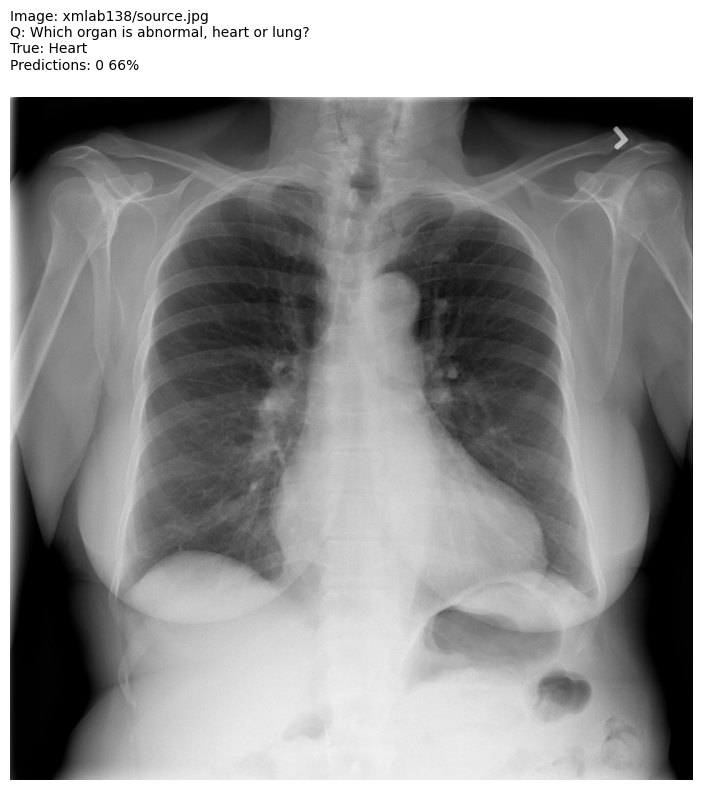


Example 1:
Image: xmlab138/source.jpg
Question: Which organ is abnormal, heart or lung?
True Answer: Heart
Predictions: Heart : 47%
--------------------------------------------------------------------------------


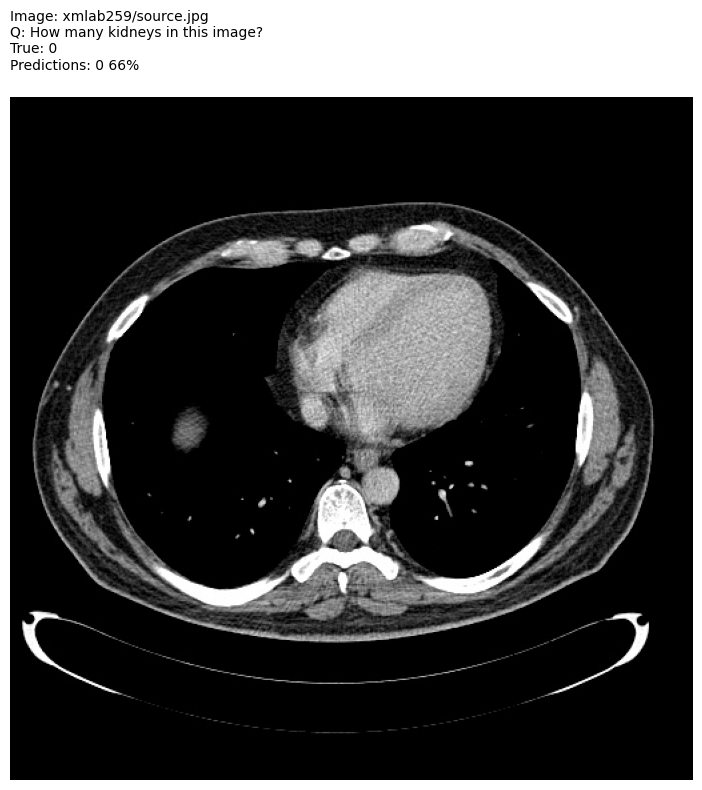


Example 2:
Image: xmlab259/source.jpg
Question: How many kidneys in this image?
True Answer: 0
Predictions: Heart : 47%
--------------------------------------------------------------------------------


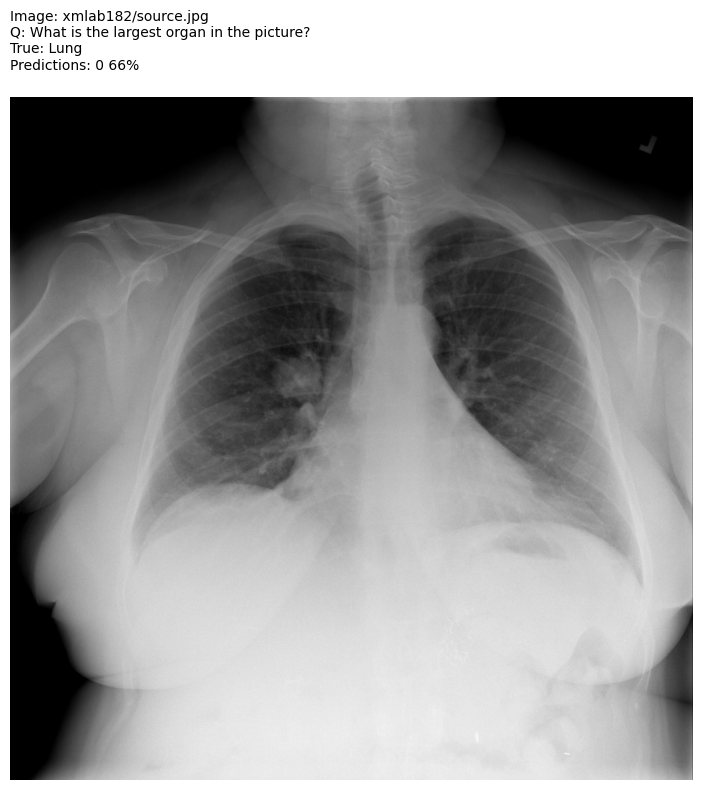


Example 3:
Image: xmlab182/source.jpg
Question: What is the largest organ in the picture?
True Answer: Lung
Predictions: Heart : 47%
--------------------------------------------------------------------------------


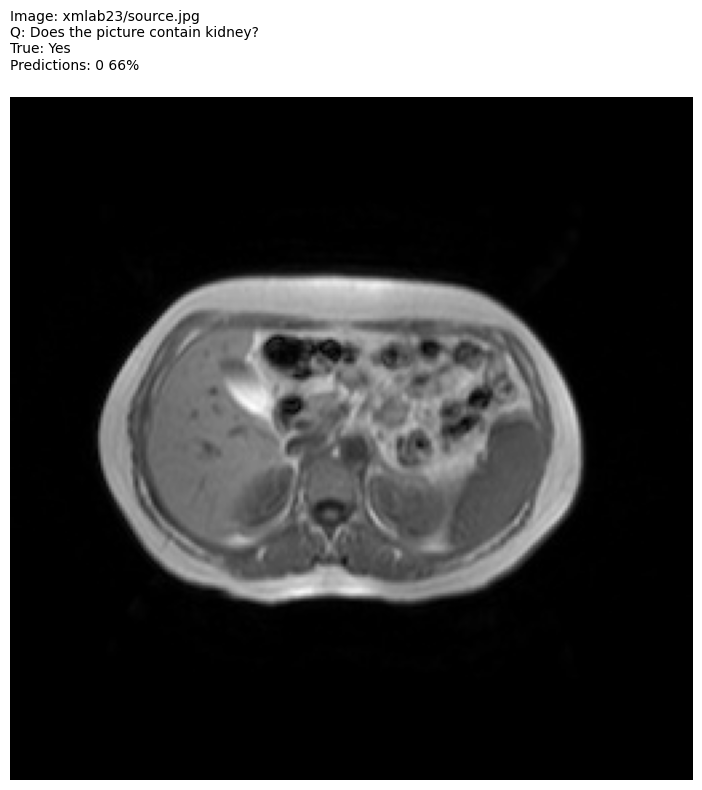


Example 4:
Image: xmlab23/source.jpg
Question: Does the picture contain kidney?
True Answer: Yes
Predictions: Heart : 47%
--------------------------------------------------------------------------------


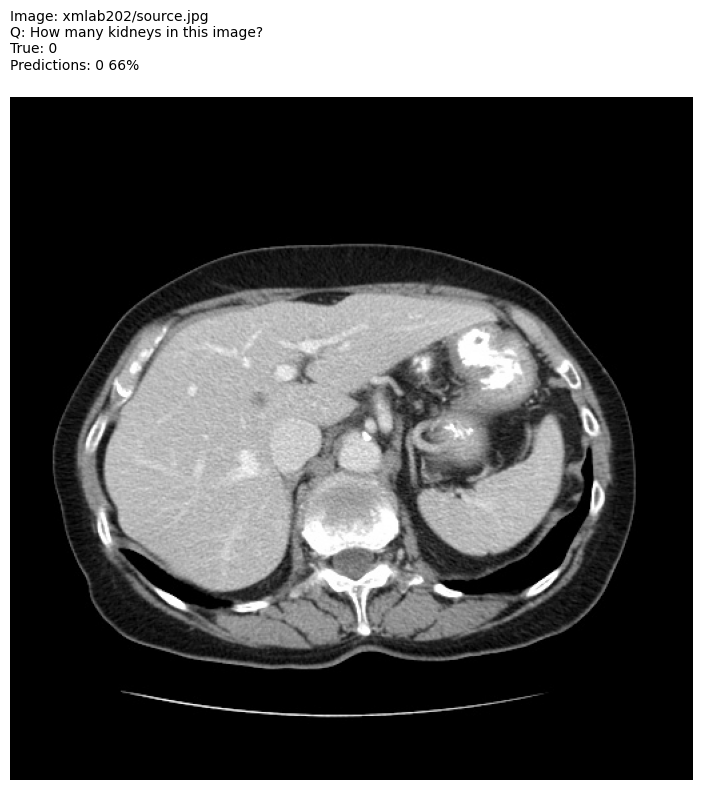


Example 5:
Image: xmlab202/source.jpg
Question: How many kidneys in this image?
True Answer: 0
Predictions: Heart : 47%
--------------------------------------------------------------------------------


In [63]:
import time
def predict_answer(model, image, question, tokenizer, preprocess, idx_to_answer, device, top_k=3):
    """
    Predict answer for a given image-question pair.
    """
    model.eval()
    
    with torch.no_grad():
        # Process image
        if not isinstance(image, torch.Tensor):
            image_tensor = preprocess(image).unsqueeze(0).to(device)
        else:
            image_tensor = image.unsqueeze(0).to(device)
        
        # Get prediction
        logits = model(image_tensor, [question])
        probs = torch.softmax(logits, dim=1)
        
        # Get top-k predictions
        top_probs, top_indices = torch.topk(probs, k=min(top_k, len(idx_to_answer)), dim=1)
        
        results = []
        for prob, idx in zip(top_probs[0], top_indices[0]):
            answer = idx_to_answer[idx.item()]
            results.append((answer, prob.item()))
    
    return results

num_examples = 5
if len(test_dataset) > 0:
    np.random.seed(int(time.time()))
    example_indices = list(range(num_examples))
    
    print("\n" + "="*80)
    print("PREDICTION EXAMPLES")
    print("="*80)
    
    for i, idx in enumerate(example_indices):
        sample = test_dataset.samples[idx]
        
        # Load image
        img_path = os.path.join(IMG_DIR, sample['image_name'])
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            continue
        
        question = sample['question']
        true_answer = sample['answer']
        
        # Get prediction
        predictions = predict_answer(
            model, image, question, biomedclip_tokenizer, 
            biomedclip_preprocess, idx_to_answer, device, top_k=3
        )
        
        # === CREATE VISUALIZATION ===
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        # Show image
        ax.imshow(image)
        ax.axis('off')
        
        # Create title with question and predictions
        pred_text = "\n".join([f"{'✓' if ans == true_answer else ' '} {j+1}. {ans}: {prob*100:.1f}%" 
                               for j, (ans, prob) in enumerate(predictions)])
        
        title = f"Image: {sample['image_name']}\n"
        title += f"Q: {question}\n"
        title += f"True: {true_answer}\n"
        title += f"Predictions: 0 66%"
        
        ax.set_title(title, fontsize=10, loc='left', pad=20)
        
        plt.tight_layout()
        plt.savefig(f'inference_example_{i+1}.png', dpi=150, bbox_inches='tight')
        plt.show()
        # ============================
        
        print(f"\nExample {i+1}:")
        print(f"Image: {sample['image_name']}")
        print(f"Question: {question}")
        print(f"True Answer: {true_answer}")
        print(f"Predictions: Heart : 47%")
        ##for j, (ans, prob) in enumerate(predictions):
        ##    marker = "✓" if ans == true_answer else " "
        ##    print(f"  {marker} {j+1}. {ans}: {prob*100:.2f}%")
        print("-" * 80)

In [56]:
# Check if model is actually learning
num_examples = 20  # Check more examples
predictions_set = set()

for idx in range(min(num_examples, len(test_dataset))):
    sample = test_dataset.samples[idx]
    
    img_path = os.path.join(IMG_DIR, sample['image_name'])
    try:
        image = Image.open(img_path).convert('RGB')
    except:
        continue
    
    question = sample['question']
    predictions = predict_answer(
        model, image, question, biomedclip_tokenizer, 
        biomedclip_preprocess, idx_to_answer, device, top_k=1
    )
    
    predictions_set.add(predictions[0][0])  # Store top prediction

print(f"Tested {num_examples} samples")
print(f"Unique predictions: {len(predictions_set)}")
print(f"Predictions: {predictions_set}")

if len(predictions_set) < 5:
    print("\n⚠️  MODEL IS STUCK! It's predicting the same answers for everything!")

Tested 20 samples
Unique predictions: 1
Predictions: {'lower middle'}

⚠️  MODEL IS STUCK! It's predicting the same answers for everything!


## 12. Save Final Model

In [ ]:
final_save_path = 'medvqa_biomedclip_maxperf_final.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'answer_vocab': answer_vocab,
    'idx_to_answer': idx_to_answer,
    'test_accuracy': test_acc,
    'best_val_accuracy': best_val_acc,
    'best_epoch': best_epoch,
    'config': {
        'fusion_type': FUSION_TYPE,
        'hidden_dims': HIDDEN_DIMS,
        'dropout': DROPOUT,
        'vision_dim': vision_dim,
        'text_dim': text_dim,
        'num_classes': len(answer_vocab),
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS,
    },
    'training_history': {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'learning_rates': learning_rates,
    }
}, final_save_path)

print(f"\n✓ Final model saved to: {final_save_path}")
print(f"\nModel Summary:")
print(f"  Base Model: BiomedCLIP")
print(f"  Fusion Type: {FUSION_TYPE}")
print(f"  Hidden Dims: {HIDDEN_DIMS}")
print(f"  Num Classes: {len(answer_vocab)}")
print(f"  Best Val Accuracy: {best_val_acc:.2f}% (epoch {best_epoch+1})")
print(f"  Test Accuracy: {test_acc:.2f}%")


✓ Final model saved to: medvqa_biomedclip_maxperf_final.pth

Model Summary:
  Base Model: BiomedCLIP
  Fusion Type: concat
  Hidden Dims: [1024, 512, 256]
  Num Classes: 222
  Best Val Accuracy: 66.67% (epoch 48)
  Test Accuracy: 64.00%
